# Getting started with SimPy
In this tutorial you will get to know the SimPy module for simulating discrete event systems. In this notebook you will see a complete example derived in small steps and implemented using SimPy, with some simple exercises interspersed. 

Good luck!

## Import modules to be used

In [133]:
%matplotlib inline
import simpy
import random
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

## A model of a small slalom hill
We will consider a model of a small alpine skiing operation with a single lift, quite common in the suburbs of Stockholm.

### Arriving skiers
We start off with a model of the customers (skiers) arriving to the facility. At first we consider the customers to arrive randomly with a mean frequency which is constant during the day. In the next step, we will make the model of arrivals more realistic.

The time between arrivals is random and can be modelled as having an exponential distribution. The probability density function of the exponential distribution with mean $\frac{1}{\lambda}$ is 
$$ f(t) = \lambda \mathrm{e}^{-\lambda t}, $$
and the probabilty distribution is
$$ F(t) = \mathrm{Pr}\,(T \le t) = \int_0^t f(\tau)d\tau = 1 - \mathrm{e}^{-\lambda t}. $$
The two functions are plotted below.

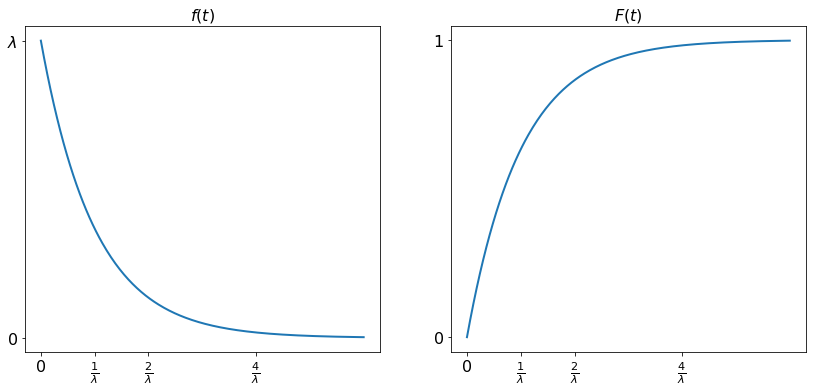

In [134]:
font_size = 16
mpl.rcParams['xtick.labelsize'] = font_size 
mpl.rcParams['ytick.labelsize'] = font_size 
mpl.rcParams['axes.titlesize'] = font_size 
mpl.rcParams['axes.labelsize'] = font_size 

t = np.linspace(0, 6, 300)
lmbda = 1 # The frequency 
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(t, lmbda * np.exp(-t*lmbda), linewidth=2)
plt.yticks([0, lmbda], ['0', '$\lambda$'])
plt.xticks([0, 1/lmbda, 2/lmbda, 4/lmbda], ['0', r'$\frac{1}{\lambda}$', r'$\frac{2}{\lambda}$', r'$\frac{4}{\lambda}$'])
plt.title('$f(t)$')
plt.subplot(1,2,2)
plt.plot(t, 1 - np.exp(-t*lmbda), linewidth=2)
plt.yticks([0, 1], ['0', '1'])
plt.xticks([0, 1/lmbda, 2/lmbda, 4/lmbda], ['0', r'$\frac{1}{\lambda}$', r'$\frac{2}{\lambda}$', r'$\frac{4}{\lambda}$'])
ttle = plt.title('$F(t)$')

From the plot of the probabilty density, we see that it is much more common to observe time between arrivals in the interval $\left[0, \; \frac{1}{\lambda}\right]$ $$ p_1 = F(\frac{1}{\lambda}) = 1-\mathrm{e}^{-1} \approx 0.63$$ than in the interval above the mean value $\left[\frac{1}{\lambda}, \; \infty \right)$ $$p_2 = 1 - p_1 \approx 0.37.$$ The single parameter $\lambda$ is the reciprocal  of the mean time, and so it is called the *mean frequency* of the distribution.

#### The customer generator process
We will now implement a random process that generates new arriving skiers. The process goes in an eternal loop, consisting of two steps: 
1. Waiting for a random period of time.
2. Generating a new customer/skier. This is of course and important event in our discrete event system.
The mean frequency of arrivals is one per two minutes. The facility is open from 08:00 ($t=0$) to 16:00 ($t=480$).

The following flowchart illustrates this simple process.

![alt text](http://alfkjartan.github.io/images/generator_process.png "A typical customer generator process")

For now, we will just register the time when the skier arrives. Further down we will actually generate and start a new skier process.

In [135]:
def skier_generator_process(env, lmbda, arrivals):
    """ Implementation of the process that generates arriving customers to the facility.
    
        Arguments
        env       --  simpy simulation environment object
        lmbda     --  the mean arrival frequency
        arrivals  --  a list to hold the time of arrivals
    """
   
    k = 0 # A counter to indicate the number of skiers created
    while True:
        # Endless loop
        yield env.timeout(random.expovariate(lmbda)) # Wait for a random interval
        k += 1
        print( "Time is %6.2f and skier %d arrives" % (env.now, k) )
        arrivals.append(env.now) # Register the time of arrival
        
env = simpy.Environment() # Create the simulation environment
lmbda = 0.5 # One arrival per two minutes on average
arr = [] # The list of arrival times
env.process( skier_generator_process(env, lmbda, arr) ) # Tell the simulator to process the skier generator process
env.run(until=30) # To not get too much output below, we simulate the first 30 minutes.

Time is   0.07 and skier 1 arrives
Time is   4.73 and skier 2 arrives
Time is   6.57 and skier 3 arrives
Time is   7.30 and skier 4 arrives
Time is   9.25 and skier 5 arrives
Time is   9.78 and skier 6 arrives
Time is  11.09 and skier 7 arrives
Time is  13.02 and skier 8 arrives
Time is  16.02 and skier 9 arrives
Time is  18.11 and skier 10 arrives
Time is  20.12 and skier 11 arrives
Time is  26.44 and skier 12 arrives
Time is  29.46 and skier 13 arrives
Time is  29.56 and skier 14 arrives


We can check the distribution of the interarrival times by plotting a histogram of the observations. Below we have commented out the print statement in the skier_generator_process, and we simulate for a whole day.

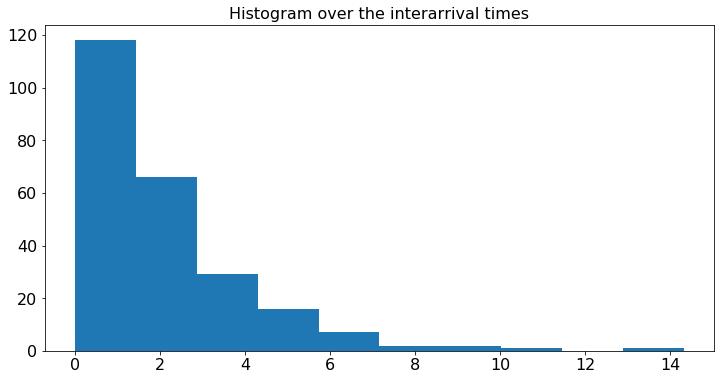

In [136]:
def skier_generator_process(env, lmbda, arrivals):
    """ Implementation of the process that generates arriving customers to the facility.
    
        Arguments
        env       --  simpy simulation environment object
        lmbda     --  the mean arrival frequency
        arrivals  --  a list to hold the time of arrivals
    """
   
    k = 0 # A counter to indicate the number of skiers created
    while True:
        # Endless loop
        yield env.timeout(random.expovariate(lmbda)) # Wait for a random interval
        k += 1
        #print( "Time is %6.2f and skier %d arrives" % (env.now, k) )
        arrivals.append(env.now) # Register the time of arrival
        
env = simpy.Environment() # Create the simulation environment
lmbda = 0.5 # One arrival per two minutes on average
arr = [] # The list of arrival times
env.process( skier_generator_process(env, lmbda, arr) ) # Tell the simulator to process the skier generator process
env.run(until=60*8) # Simulate a day

interArrivalTimes = np.diff(np.array(arr)) # The interarrival times are the difference between the arrival times
plt.figure(figsize=(12,6))
plt.hist(interArrivalTimes)
plt.title('Histogram over the interarrival times')

#### Generating random numbers
To see the available distributions that you can draw samples from with the `random` module do 

In [69]:
?random

And to see information about a particular distribution do

In [44]:
?random.expovariate

### Exercise 1
Try some other distribution for the time between arrivals in `skier_generator_proc`, and plot the histogram. 

In [ ]:
# YOUR CODE HERE


### Exercise 2
Run the simulation repeated times and note how many skiers arrived in total during the day. The number will vary between simulations (unless you set a deterministic time between arrivals in your process). Is it what you expected? 

## A more realistic arrival process
Obviously, it is quite unrealistic that the frequency of skiers arriving is constant over the day. Most arrive in the morning to get a whole day of skiing, then the arrival frequency drops off. Possibly it picks up towards the middle of the day for people that just want to ski half a day. The arrival frequency will vary over the day, and maybe it could look like the  graph below.

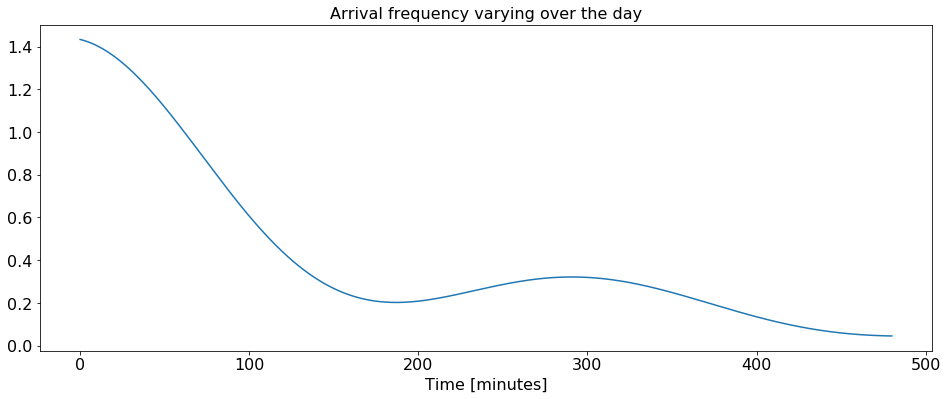

In [59]:
def arrival_freq(t):
    """ Returns the arrival frequency as a function of time (minutes from start of day) """
    return np.exp(-t/200)*(1 + 0.5*np.cos(t*2*np.pi/300 - np.pi/6))

t = np.linspace(0, 480, 481)
plt.figure(figsize=(16,6))
plt.plot(t, arrival_freq(t) )
plt.title('Arrival frequency varying over the day')
plt.xlabel('Time [minutes]')

### Exercise 3
Note in the code above that a function is defined `arrival_freq`, and then plotted. Modify `skier_generator_proc` to use this function when generating inter-arrival times.  

In [129]:
# YOUR CODE HERE


(0, 15)

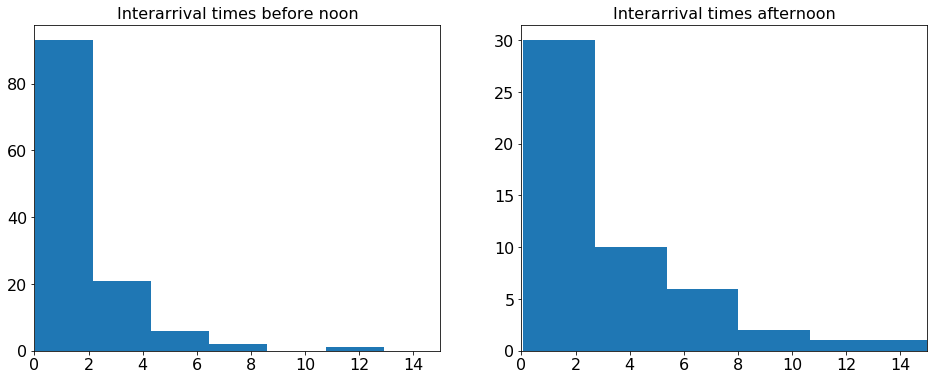

In [140]:
# %load non_stationary_skier_process.py
def skier_generator_process(env, arrivals):
    """ Implementation of the process that generates arriving customers to the facility.
    
        Arguments
        env       --  simpy simulation environment object
        arrivals  --  a list to hold the time of arrivals
    """
   
    k = 0 # A counter to indicate the number of skiers created
    while True:
        # Endless loop
        yield env.timeout( random.expovariate(arrival_freq(env.now)) ) # Wait for a random interval, depending on time of day
        k += 1
        #print( "Time is %6.2f and skier %d arrives" % (env.now, k) )
        arrivals.append(env.now) # Register the time of arrival
        
env = simpy.Environment() # Create the simulation environment
lmbda = 0.5 # One arrival per two minutes on average
arr = [] # The list of arrival times
env.process( skier_generator_process(env, arr) ) # Tell the simulator to process the skier generator process
env.run(until=60*8) # Simulate a day


interArrivalTimesAM = np.diff( np.array( [t for t in arr if t<(12-8)*60] ) ) # The interarrival times first half of the day
interArrivalTimesPM = np.diff( np.array( [t for t in arr if t>(12-8)*60] ) ) # The interarrival times second half of the day

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.hist(interArrivalTimesAM)
plt.title('Interarrival times before noon')
plt.xlim( (0, 15))
plt.subplot(122)
plt.hist(interArrivalTimesPM)
plt.title('Interarrival times afternoon')
plt.xlim( (0, 15))

### The skier process
So far we have only implemented a customer generator process that doesn't really generate any customer processes. I just register the time when the customer arrives. So now our objective is to model the process of a skier.

There are many interesting events that an happen to a skier in the course of a day at the ski resort. Here we will only be interested in those events that has to do with the skiers use of limited resources, mainly the skilift. But before we do that, we'll look at an extremely simplified model of the skier process. 

Consider a model where there is only two events: 1) The skier arrives at the facility and 2) the skier leaves after having had enough fun in the slopes. This simple process is illustrated below, where there is just a single time delay (Hold) between the arrival event and the exit event.

![A very simple customer process](http://alfkjartan.github.io/images/simple_customer_process.png "A very simple customer process")

We need to describe the time spent in the slopes, $T_s$. This varies of course, and so we are looking for a probability distribution that gives a reasonable description of the time. The exponential distribution does no seem apropriate in this case, since it is more probable that a typical skier will make use of the available time that day to ski. The time cannot be negative, of course, and it cannot extend (much) beyond the time left till the skilift closes. Maybe a distribution such as the one below is reasonable

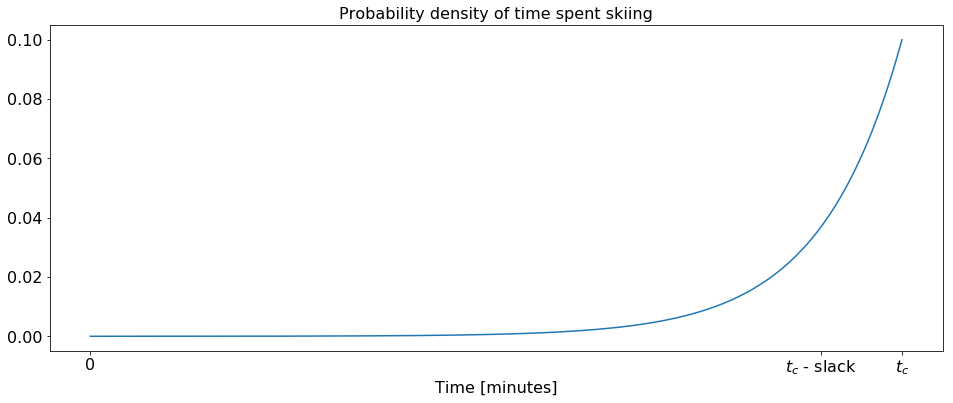

In [78]:
def pdf_time_spent_skiing(t, timeToEndOfDay, meanSlackTime):
    """ 
        Function discribing the probability density of the time spent skiing for a skier that arrives when there are
        timeToEndOfDay minutes left till the skilift closes. The argument meanSlackTime is the average slack time
        from the skier leaves till the skilift actually closes."""
    return 1.0/meanSlackTime * np.exp( - 1.0/meanSlackTime * (timeToEndOfDay-t) )

timeToClosing = 100
slackTime = 10
t = np.linspace(0, timeToClosing, 400)

plt.figure(figsize=(16,6))
plt.plot(t, pdf_time_spent_skiing(t, timeToClosing, slackTime) )
plt.title('Probability density of time spent skiing')
plt.xlabel('Time [minutes]')
xt=plt.xticks([0, timeToClosing-slackTime, timeToClosing], ['0', '$t_c$ - slack', '$t_c$'])

The distribution plotted was obtained by basically flipping the exponential  distribution. The distribution makes sense. It is very little probability that the time spent in the slope is short, and high probability that the time spent is near the limit, $t_c$, which is the time left till the skilift closes.

An implementation of the skier process, and an updated skier generator process are given below.

In [97]:
def skier_proc(env, name, slackTime, population):
    """
        Process describing a skier.
    
        Arguments
        env        -- the simulation environment object
        slackTime  -- the mean time that a skier will leave before the skilift closes
        population -- a list holding the names of skiers currently in the facility
    """
    
    #print( "Time is %6.2f and %s is arriving." % (env.now, name) )
    population.append(name) # Add name to list of people skiing
    timeLeft = 480 - env.now  # Minutes left of the day
    timeSkiing = timeLeft - random.expovariate(1.0/slackTime) # Sample from the distribution 
    yield env.timeout( np.max( (0, timeSkiing) ) ) # Note that we make sure not to accidently get a negative value
    #print( "Time is %6.2f and %s is leaving." % (env.now, name) )
    population.remove(name) 
    
    
def skier_generator_process(env, slackTime, population, arrivals):
    """ Implementation of the process that generates arriving customers to the facility.
    
        Arguments
        env        --  simpy simulation environment object
        slackTime  -- the mean time that a skier will leave before the skilift closes 
        population -- a list holding the names of skiers currently in the facility
        arrivals   --  a list to hold the time of arrivals
    """
   
    k = 0 # A counter to indicate the number of skiers created
    while True:
        # Endless loop
        yield env.timeout( random.expovariate(arrival_freq(env.now)) ) # Wait for a random interval
        k += 1
        env.process( skier_proc(env, "Skier-%d" %k, 10, population) ) # Generating and starting up skier process
        arrivals.append(env.now) # Register the time of arrival

env = simpy.Environment() # Create the simulation environment
slackT = 15
arr = [] # The list of arrival times
pop = [] # List of people in the facility
env.process( skier_generator_process(env, slackT, pop, arr) ) # Process the skier generator process
env.run(until=60*8 - 1) # Simulate until 1 minutes remains of the day. 
print("Skiers left when there are one minute to closing time:")
print( pop ) # Any left in the slopes?


arr = [] # The list of arrival times
pop = [] # List of people in the facility
env.process( skier_generator_process(env, slackT, pop, arr) ) # Process the skier generator process
env.run(until=60*8) # Simulate the whole day. 
print("Skiers left at closing time:")
print( pop ) # Any left in the slopes?

Skiers left when there are one minute to closing time:
['Skier-15', 'Skier-48', 'Skier-51', 'Skier-52', 'Skier-55', 'Skier-58', 'Skier-62', 'Skier-66', 'Skier-110', 'Skier-140', 'Skier-143', 'Skier-152', 'Skier-170', 'Skier-183', 'Skier-186', 'Skier-200', 'Skier-205']
Skiers left at closing time:
[]


### Exercise 4
Modify the code above so that you can register the **number of skiers** that are currently in the facility during the simulation. When is the peak? How many skiers are there at the peak? What happens to these values if you change the slack time?

In [98]:
# YOUR CODE HERE

### A process for the skilift
Much of a day at the slopes involves queuing for the skilift. The skilift is a limited resource, the demand is usually high, and the skiers arrive to the bottom of the slope with variation. A lift chair is often not available at the time the skier arrives to the bottom of the skilift, leading to queues. 

We consider here a single skilift with chairs that seat two. The lift runs at a constant speed of 3 m/s. The distance to the top is 600 m and it is 12 m between the chairs. 

There are two different ways of modelling the skilift. 
1. There are 1200/12=100 double seats. One cycle of each chair takes 1200/3/60 = 20/3 minutes, and in this time 0, 1 or 2 customers are served. We can model the process of a chair, and have 120 such processes in our simulation model. Care must be taken that the 120 processes are synchronized properly so that one chair-process picks up skiers every 4th second. At the top of the slope the chair should let go of the skier(s).
2. Once a skier has jumped on the chair, the ride up to the top is simply a delay, which can be included in the skier process. The skilift process will then just pick 0, 1 or 2 skiers out of the queue every 4 seconds. This way of modelling the process is somewhat more abstract, but simpler and more efficient, since only one skilift process is needed, not 100 chair-processes. This model is described in the flow chart below

![alt text](http://alfkjartan.github.io/images/skilift_process.png "A skilift process")

In [125]:
def skilift_proc(env, queue, timeBetweenChairs=4.0/60, seatsPerChair=2 ):
    """
        Implementation of the skilift process
        
        Arguments
        env               -- the simulation environment object
        queue             -- a list holding waiting skiers. Each skier is represented by an event object that will
                             be triggered once the skier is on the chair.
        timeBetweenChairs -- the model assumes constant speed of the skilift
        seatsPerChair     -- maximum number of skiers that fit in one chair
    """
    while True:
        skiersToPickup = np.min( (seatsPerChair, len(queue)) )
        if skiersToPickup:
            for i in range(skiersToPickup):
                skier = queue.pop(0) # Take from the front of the queue
                skier.succeed() # This tells the skier that she is on the chair
        yield env.timeout(timeBetweenChairs) # Wait till the next chair arrives


### A more interesting model for the skiers
The skiers arrive to the bottom of the lift and enters the queue, where they wait until they are at the front of the queue. The skiers jumps onto the chair, which after 600/3 = 200 seconds has taken them to the top. Then they ski down to the bottom again. This goes on until it is time for the skier to go home. The process is illustrated below.

![alt text](http://alfkjartan.github.io/images/skier_process.png "A skier process")

We will need a model for the time it takes to ski down to the bottom of the slope. Clearly, there is a minimum time this can take when only gravity is the driving force. Let's assume it is 1 minute. Most skiers use more or less the same amount of time, with a few slow beginners and a few crazy racers. A suitable probability density function for the distribution for the times it takes to go down could look like the function below, which is a so-called *Erlang distribution*, here with shape parameter 3, and shifted by 1 to the right.

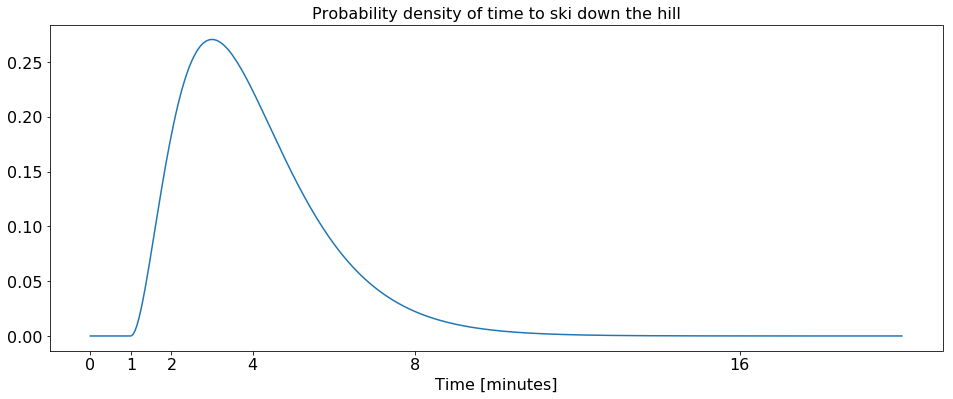

In [126]:
from scipy.stats import erlang
t = np.linspace(0, 20, 400)
plt.figure(figsize=(16,6))
plt.plot(t, erlang.pdf(t, 3, 1) )
plt.title('Probability density of time to ski down the hill')
plt.xlabel('Time [minutes]')
xt=plt.xticks([0, 1, 2, 4, 8, 16])

Now we are ready to implement the more interesting skier process. 

In [128]:
import pdb
def skier_proc(env, name, slackTime, queue, population):
    """
        Implementation of the skier process. The skier will queue for the lift, go up, ski down
        and so on until it is time to go home. The accumulated time spent in queue is measured.
        
        Arguments
        env          -- the simulation environment object
        name         -- unique name for each skier
        slackTime    -- the mean time that a skier will leave before the skilift closes 
        queue        -- a list holding the skiers waiting for the skilift
        population   -- a list holding the names of skiers currently in the facility
    """
    population.append(name) # Add name to list of people skiing
    timeToPackup = 480 - random.expovariate(1.0/slackTime) # Sample from the distribution 
    timeInQ = 0
    while env.now < timeToPackup:
        onChairEvent = env.event() # Generate an event that is to be triggered by the skilift
        queue.append(onChairEvent) # The skier in the queue is represented by her event object
        timeWhenEnteringQ = env.now
        yield onChairEvent         # Wait until the onChairEvent is triggered      
        timeInQ += (env.now - timeWhenEnteringQ)
        # Continues here when on the chair
        yield env.timeout( 600.0/3/60 )  # Wait the time it takes to go up
        timeDownhill = 1.0 + random.gammavariate(3, 1)  # THe time it take ski down
        yield env.timeout( timeDownhill) 
        
    print( "Time is %6.2f and %s is leaving, having spent %6.2f minutes waiting in line" % (env.now, name, timeInQ) )
    population.remove(name) 

def skier_generator_process(env, slackTime, queue, population, arrivals):
    """ Implementation of the process that generates arriving customers to the facility.
    
        Arguments
        env        --  simpy simulation environment object
        slackTime  -- the mean time that a skier will leave before the skilift closes 
        queue      -- a list holding the skiers waiting for the skilift
        population -- a list holding the names of skiers currently in the facility
        arrivals   --  a list to hold the time of arrivals
    """
   
    k = 0 # A counter to indicate the number of skiers created
    while True:
        # Endless loop
        yield env.timeout( random.expovariate(arrival_freq(env.now)) ) # Wait for a random interval
        k += 1
        env.process( skier_proc(env, "Skier-%d" %k, 10, queue, population) ) # Generating and starting up skier process
        arrivals.append(env.now) # Register the time of arrival

env = simpy.Environment() # Create the simulation environment
slackT = 15
arr = [] # The list of arrival times
pop = [] # List of people in the facility
queue = [] # The queue at the bottom of the skilift
env.process( skilift_proc(env, queue))
env.process( skier_generator_process(env, slackT, queue, pop, arr) ) # Process the skier generator process
env.run(until=60*8 - 1) # Simulate until 1 minutes remains of the day. 
print("Skiers left in line when there are one minute to closing time:")
print( queue ) # Any left in the slopes?


Time is 422.06 and Skier-111 is leaving, having spent   2.26 minutes waiting in line
Time is 435.77 and Skier-37 is leaving, having spent   4.17 minutes waiting in line
Time is 435.88 and Skier-135 is leaving, having spent   4.14 minutes waiting in line
Time is 439.62 and Skier-155 is leaving, having spent   2.15 minutes waiting in line
Time is 443.70 and Skier-124 is leaving, having spent   3.63 minutes waiting in line
Time is 446.22 and Skier-149 is leaving, having spent   2.94 minutes waiting in line
Time is 447.88 and Skier-47 is leaving, having spent   5.43 minutes waiting in line
Time is 451.06 and Skier-61 is leaving, having spent   3.11 minutes waiting in line
Time is 452.43 and Skier-49 is leaving, having spent   4.01 minutes waiting in line
Time is 452.57 and Skier-59 is leaving, having spent   3.59 minutes waiting in line
Time is 452.80 and Skier-35 is leaving, having spent   3.92 minutes waiting in line
Time is 453.81 and Skier-106 is leaving, having spent   4.10 minutes wa

### Exercise 5
Modify the code above so that you can register the total time spent in the queue for all skiers that are simulated. Calculate the mean value. How does this change if we double the capacity of the chairs (seating 4 instead of 2)?

In [137]:
#YOUR CODE HERE


### Exercise 6
Modify the code so that you can register the number of unused chairs going up. The fraction of the resource that on average is being utilized is called the *utilization*, and is an important performance measure. Calculate this for the simulation model. 

In [ ]:
#YOUR CODE HERE